In [5]:
!pip install statsmodels
!pip install seaborn


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.feature_selection import RFE
import scipy.stats as stats
from statsmodels.stats.stattools import durbin_watson


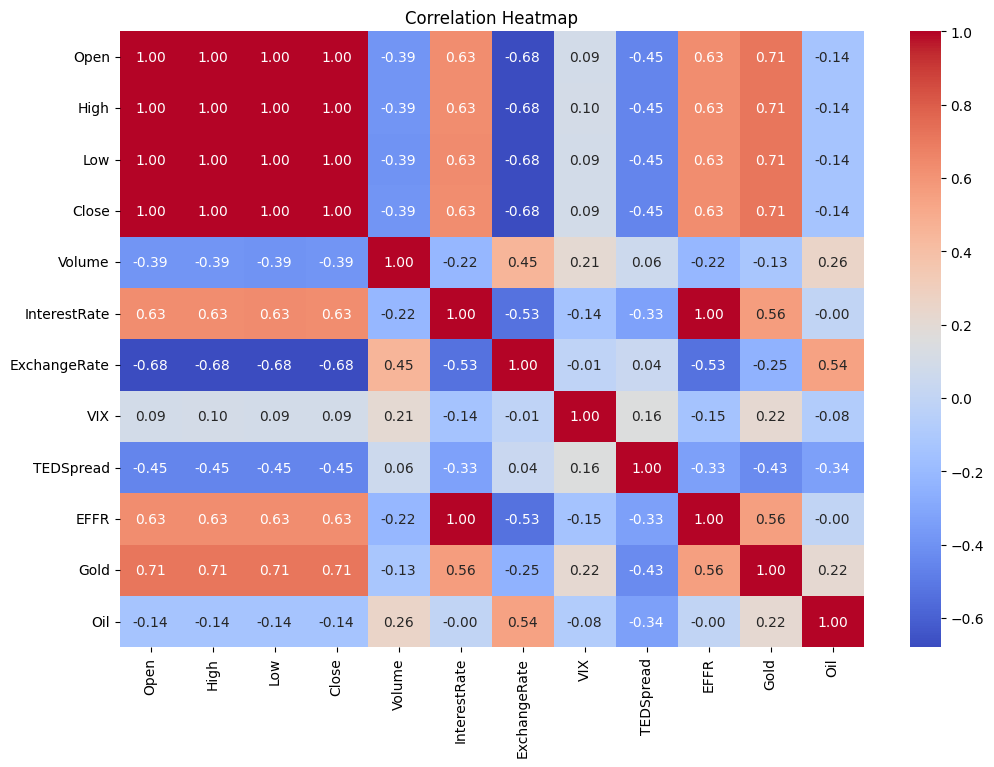

In [15]:
# Load the dataset
url = r"C:\Users\anany\OneDrive\Desktop\SEM1\5302 principles of data science\nasdq.csv"
data = pd.read_csv(url.replace("\\", "/"))
data.set_index('Date', inplace=True)


# Correlation heatmap
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

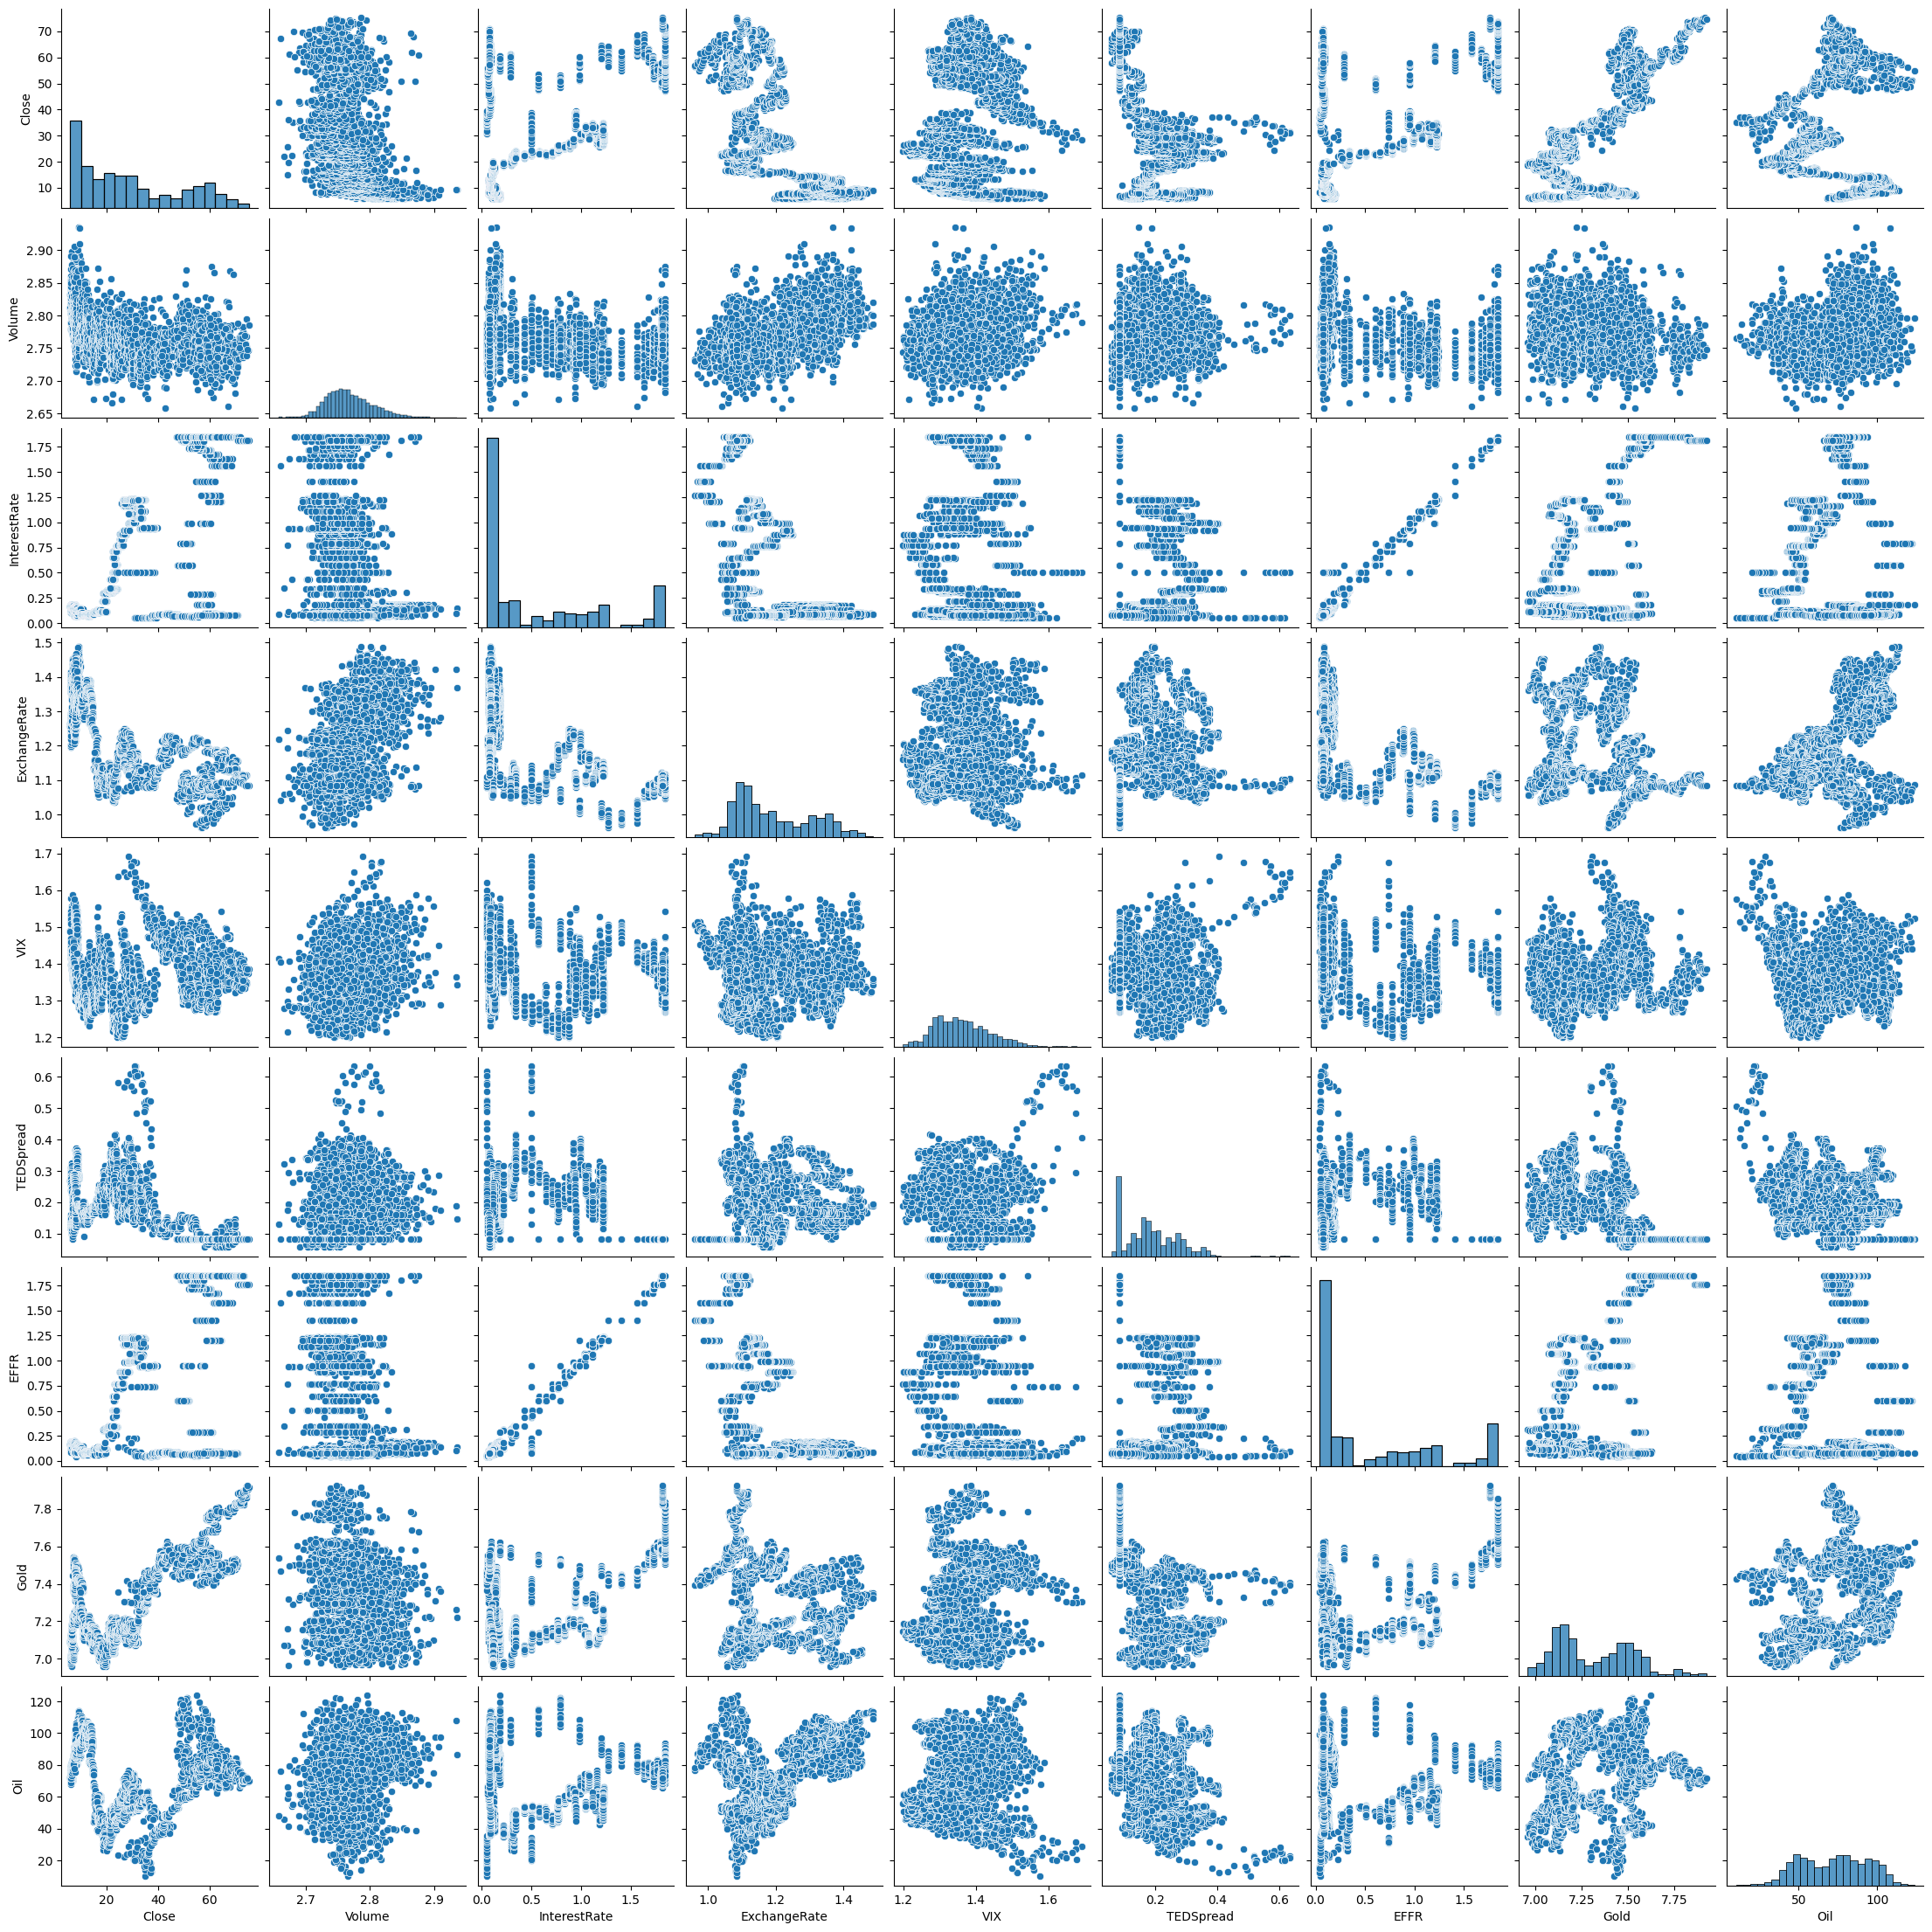

In [22]:
# Identify and filter correlated features
correlated_features = correlation_matrix[abs(correlation_matrix['Close']) < 0.75].index.tolist()
if 'Close' in correlated_features:
    correlated_features.remove('Close')

# Additional check: Remove one of 'effr' or 'interest_rate' if both are present
if 'effr' in correlated_features and 'interest_rate' in correlated_features:
    correlated_features.remove('interest_rate')  # Example: remove 'interest_rate' and keep 'effr'

#Pairplot (Scatterplot Matrix)
# Pairplot between dependent and independent variables
sns.pairplot(data[['Close'] + correlated_features])
plt.show()

['Volume', 'InterestRate', 'ExchangeRate', 'VIX', 'TEDSpread', 'EFFR', 'Gold', 'Oil']


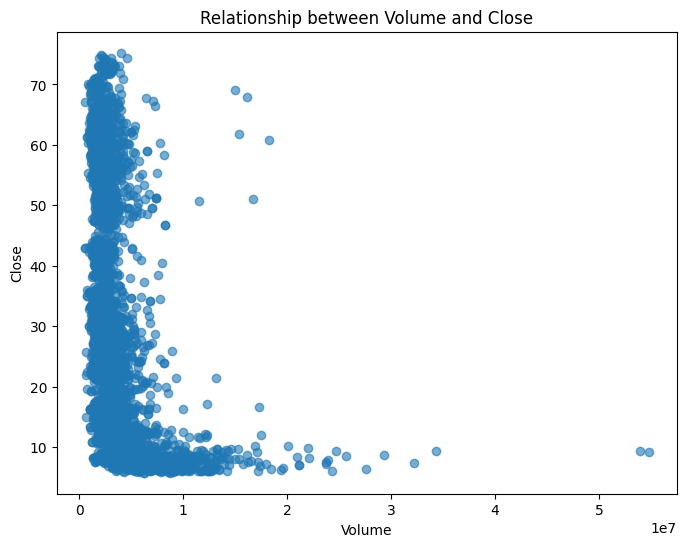

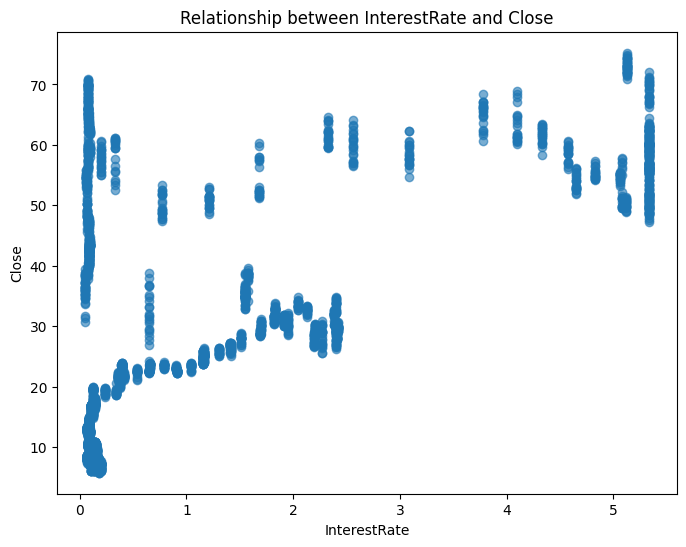

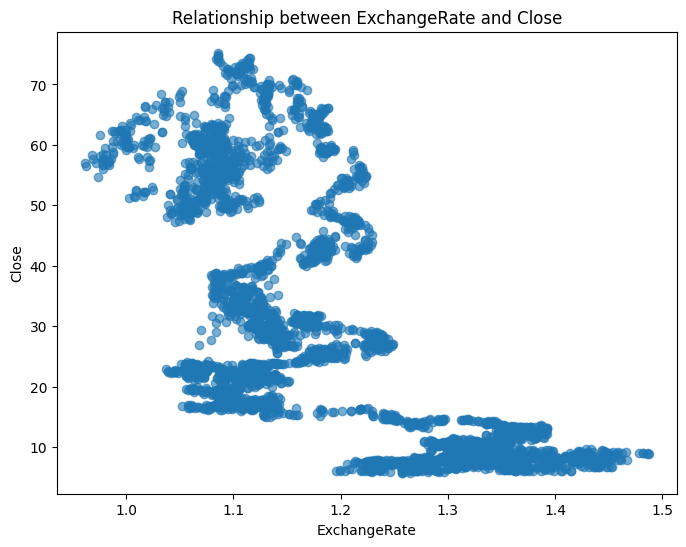

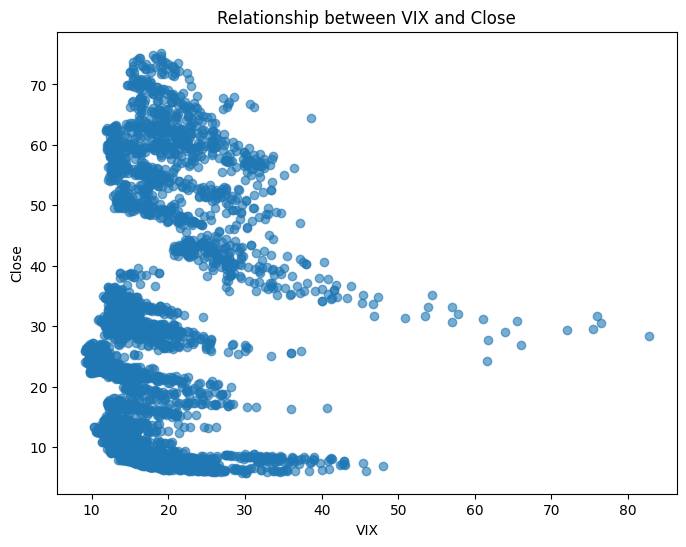

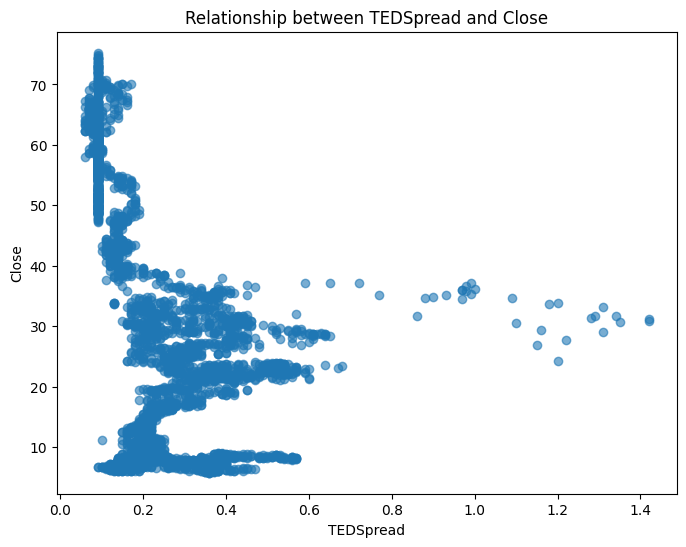

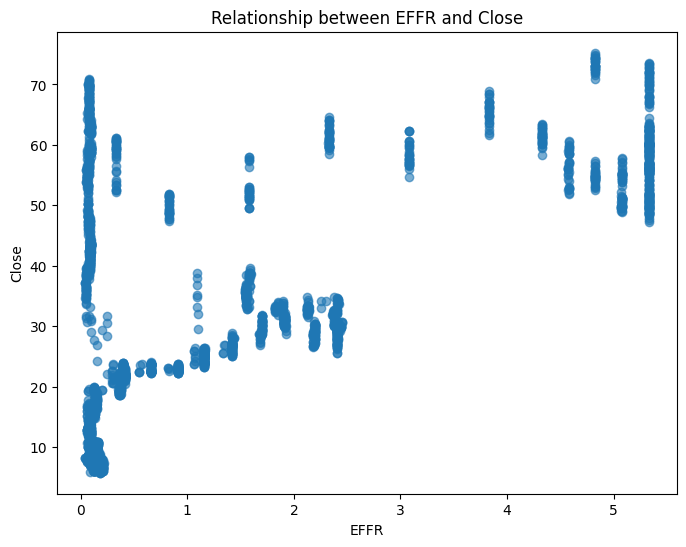

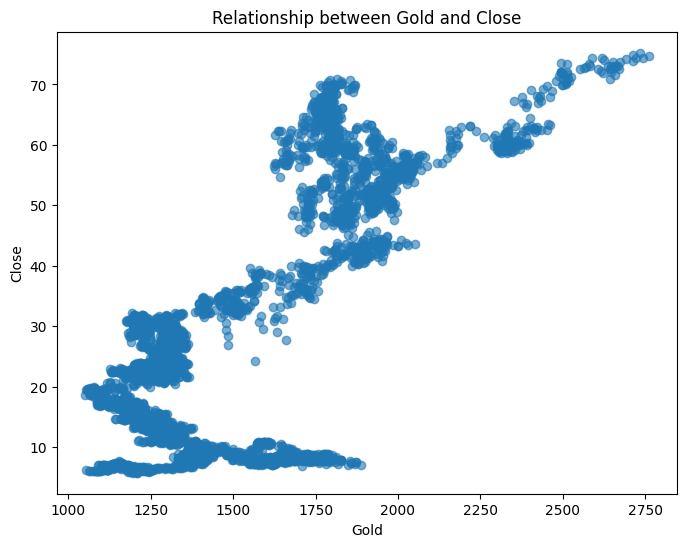

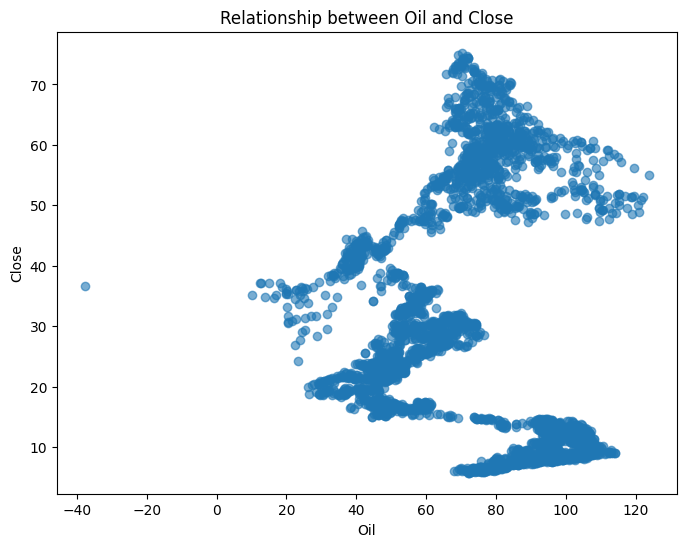

In [17]:
#Scatter Plots for Key Features vs Target
# Scatter plots for key features against 'Close' price
print(correlated_features)
for feature in correlated_features:
    plt.figure(figsize=(8, 6))
    plt.scatter(data[feature], data['Close'], alpha=0.6)
    plt.title(f'Relationship between {feature} and Close')
    plt.xlabel(feature)
    plt.ylabel('Close')
    plt.show()

In [ ]:
# Remove negative Oil outliers (COVID-19 impact)
data = data[data['Oil'] > 0]


# Detect columns with outliers using IQR method
columns_outlier_list = []
for column in data:
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)
    IQR = Q3 - Q1
    lower_limit = Q1 - (1.5 * IQR)
    upper_limit = Q3 + (1.5 * IQR)
    IQR_outliers = data[(data[column] > upper_limit) | (data[column] < lower_limit)]
    if IQR_outliers.shape[0] > 0:
        columns_outlier_list.append(column)


# Log transformation for outliers
for column in columns_outlier_list:
    data[column] = np.log1p(data[column])

<Figure size 1200x800 with 0 Axes>

C:\Users\anany\AppData\Local\Temp\ipykernel_2216\377138438.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.replace([np.inf, -np.inf], np.nan, inplace=True)
C:\Users\anany\AppData\Local\Temp\ipykernel_2216\377138438.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(X.mean(), inplace=True)
c:\Users\anany\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\anany\AppData\Loca

feature ranking is :
        Feature  Ranking
0        Volume        1
1  InterestRate        1
2  ExchangeRate        1
3           VIX        1
4     TEDSpread        1
5          EFFR        1
6          Gold        1
7           Oil        1
Coefficients of the Linear Regression Model:
        Feature  Coefficient
6          Gold     7.547251
1  InterestRate     5.009167
3           VIX     0.478966
7           Oil    -1.627853
0        Volume    -2.413499
5          EFFR    -3.981605
4     TEDSpread    -6.664184
2  ExchangeRate    -7.796124


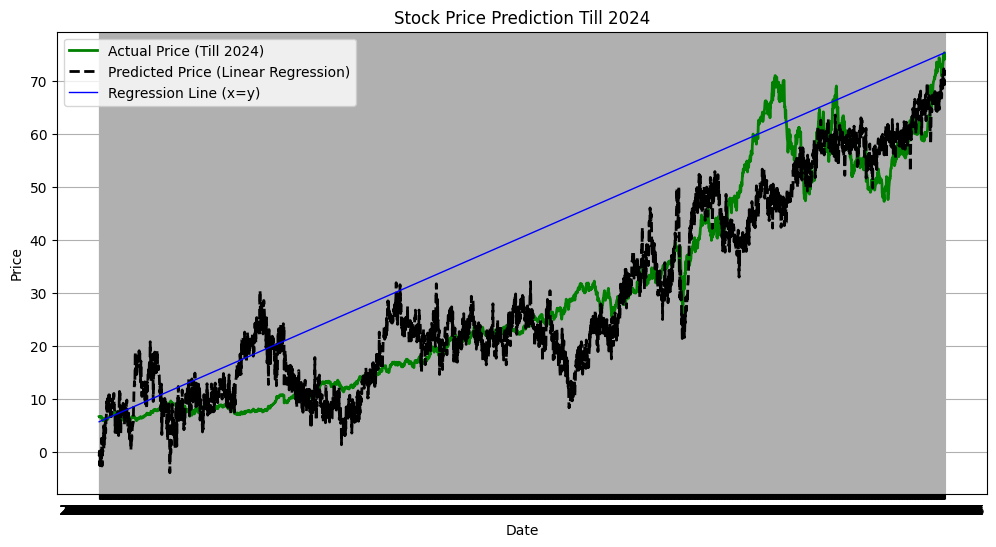

Linear Regression Model:
RMSE for Training Set: 7.294752380998224
R-squared for Training Set: 0.8625869208510903
RMSE for Testing Set: 7.281915148101966
R-squared for Testing Set: 0.8620011510288027
RMSE for All Years Till 2024: 7.292185430750055
R-squared for All Years Till 2024: 0.8625384968113506
RRMSE for Training Set: 24.78%
RRMSE for Testing Set: 25.69%
RRMSE for All Years Till 2024: 24.95%


In [36]:


# Prepare data with filtered features
X = data[correlated_features]
y = data['Close']  # Target variable: Close price

# Handle missing values by filling with column mean
X.replace([np.inf, -np.inf], np.nan, inplace=True)
X.fillna(X.mean(), inplace=True)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature selection using RFE with Linear Regression
lr_model = LinearRegression()
rfe = RFE(estimator=lr_model, n_features_to_select=8)
X_rfe = rfe.fit_transform(X_scaled, y)

#Ranking of Features:
feature_ranking = pd.DataFrame({'Feature': X.columns, 'Ranking': rfe.ranking_})
feature_ranking = feature_ranking.sort_values(by='Ranking')
print("feature ranking is :")
print(feature_ranking)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_rfe, y, test_size=0.2, random_state=42)

# Train the Linear Regression model
lr_model.fit(X_train, y_train)

# Make predictions for the training and testing sets
y_train_pred_lr = lr_model.predict(X_train)
y_test_pred_lr = lr_model.predict(X_test)

# Calculate RMSE and R-squared for training and testing sets
rmse_train_lr = mean_squared_error(y_train, y_train_pred_lr, squared=False)
r2_train_lr = r2_score(y_train, y_train_pred_lr)
rmse_test_lr = mean_squared_error(y_test, y_test_pred_lr, squared=False)
r2_test_lr = r2_score(y_test, y_test_pred_lr)

# Make predictions for the full dataset
X_full_scaled = scaler.transform(X)
X_full_rfe = rfe.transform(X_full_scaled)
data = data.loc[X.index]  # Align the data index with the scaled features
data['Predicted_Close_LR'] = lr_model.predict(X_full_rfe)

# Filter data till 2024
data_2024 = data[data.index <= '2024-12-31']
y_2024 = y.loc[data_2024.index]

# Display coefficients of the Linear Regression model
coefficients = lr_model.coef_
selected_feature_names = np.array(correlated_features)[rfe.support_]  # Features selected by RFE
coeff_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

print("Coefficients of the Linear Regression Model:")
print(coeff_df)

# Calculate RMSE and R-squared for all available years till 2024
rmse_all_2024_lr = mean_squared_error(y_2024, data_2024['Predicted_Close_LR'], squared=False)
r2_all_2024_lr = r2_score(y_2024, data_2024['Predicted_Close_LR'])

# Define a function to calculate RRMSE
def calculate_rrmse(y_actual, y_pred):
    rmse = mean_squared_error(y_actual, y_pred, squared=False)
    mean_actual = np.mean(y_actual)
    rrmse = (rmse / mean_actual) * 100
    return rrmse

# Calculate RRMSE for Training Set
rrmse_train = calculate_rrmse(y_train, y_train_pred_lr)

# Calculate RRMSE for Testing Set
rrmse_test = calculate_rrmse(y_test, y_test_pred_lr)

# Calculate RRMSE for All Years Till 2024
rrmse_all_2024 = calculate_rrmse(y_2024, data_2024['Predicted_Close_LR'])


# Plot Actual and Predicted prices for all available years till 2024
plt.figure(figsize=(12, 6))
plt.plot(data_2024.index, y_2024, label='Actual Price (Till 2024)', color='green', linewidth=2)
plt.plot(data_2024.index, data_2024['Predicted_Close_LR'], label='Predicted Price (Linear Regression)', color='black', linestyle='--', linewidth=2)


# Plot the regression line (x = y line)
x_y_line = np.linspace(y_2024.min(), y_2024.max(), len(data_2024))
plt.plot(data_2024.index, x_y_line, label='Regression Line (x=y)', color='blue', linestyle='-', linewidth=1)


plt.title('Stock Price Prediction Till 2024')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Display evaluation metrics for training, testing, and all available years till 2024
print(f"Linear Regression Model:")
print(f"RMSE for Training Set: {rmse_train_lr}")
print(f"R-squared for Training Set: {r2_train_lr}")
print(f"RMSE for Testing Set: {rmse_test_lr}")
print(f"R-squared for Testing Set: {r2_test_lr}")
print(f"RMSE for All Years Till 2024: {rmse_all_2024_lr}")
print(f"R-squared for All Years Till 2024: {r2_all_2024_lr}")

# Display RRMSE values
print(f"RRMSE for Training Set: {rrmse_train:.2f}%")
print(f"RRMSE for Testing Set: {rrmse_test:.2f}%")
print(f"RRMSE for All Years Till 2024: {rrmse_all_2024:.2f}%")

In [24]:
#MODEL DIAGNOSIS SUMMARY - tabular summary of key findings 
results_df = pd.DataFrame({
    'Metric': ['RMSE', 'R-squared', 'RRMSE'],
    'Training': [rmse_train_lr, r2_train_lr, rrmse_train],
    'Testing': [rmse_test_lr, r2_test_lr, rrmse_test],
    'All Years Till 2024': [rmse_all_2024_lr, r2_all_2024_lr, rrmse_all_2024]
})
print(results_df)

      Metric   Training    Testing  All Years Till 2024
0       RMSE   7.535783   7.515990             7.531827
1  R-squared   0.853356   0.852987             0.853355
2      RRMSE  25.593710  26.511209            25.771823


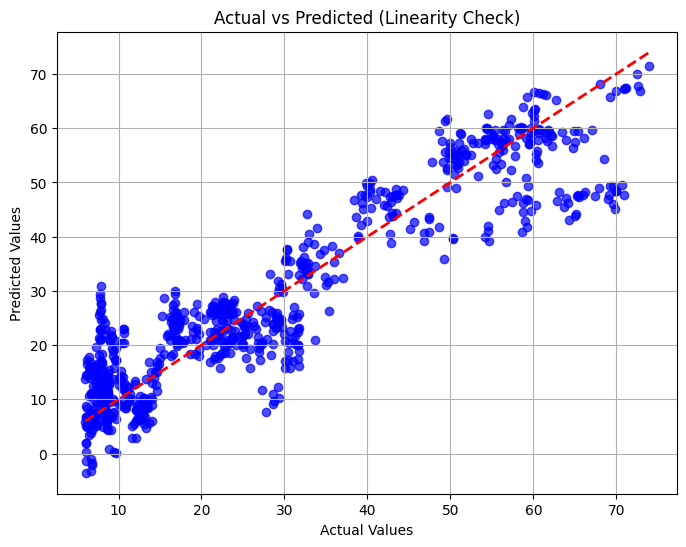

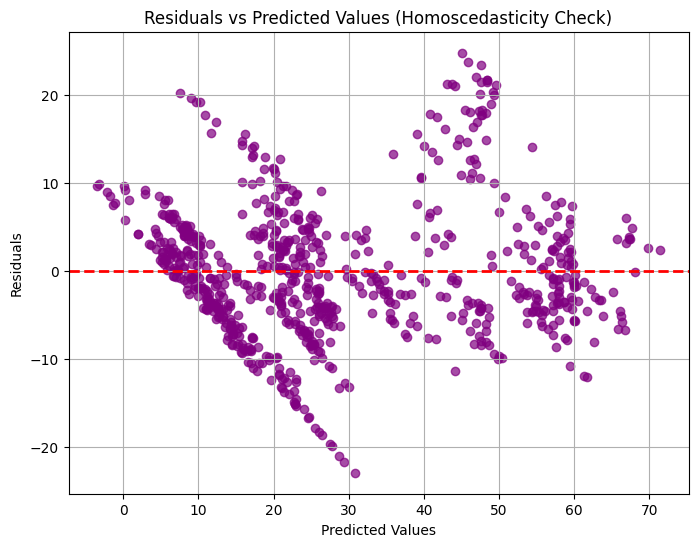

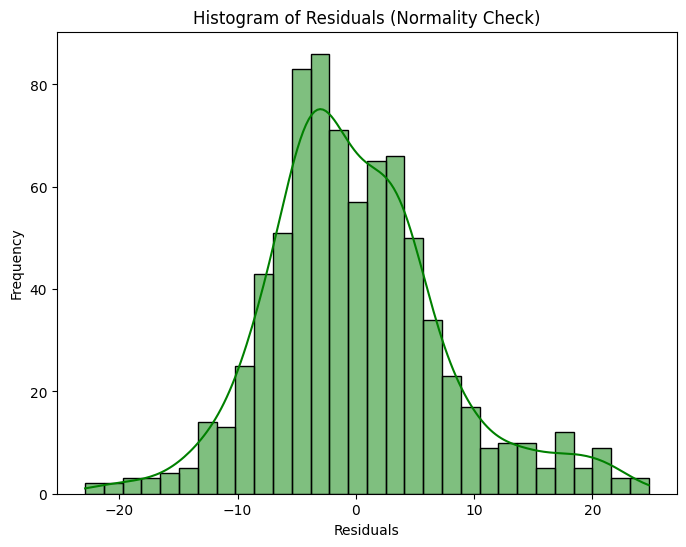

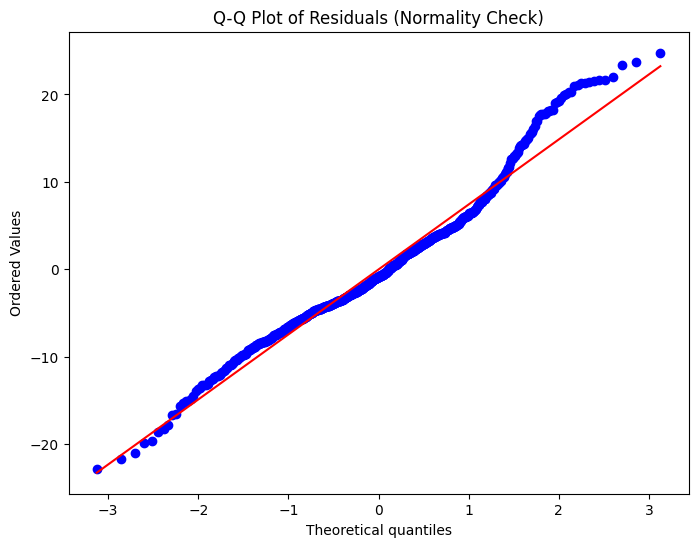

Durbin-Watson Statistic: 2.02


In [25]:
# to validate assumptions of linear regression (homogenity of residuals), we check 1. linearity, 2. homoscedasticity, 3. normality of residuals and 4. independence of residuals
# linearity check
#Plot predicted values vs. actual values to check for linear relationships.
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_test_pred_lr, alpha=0.7, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)  # Line x = y
plt.title('Actual vs Predicted (Linearity Check)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


# homoscedasticity check
#Plot residuals vs. predicted values. Residuals should not display patterns and should have constant variance.
residuals = y_test - y_test_pred_lr

plt.figure(figsize=(8, 6))
plt.scatter(y_test_pred_lr, residuals, alpha=0.7, color='purple')
plt.axhline(y=0, color='red', linestyle='--', lw=2)
plt.title('Residuals vs Predicted Values (Homoscedasticity Check)')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)
plt.show()

#Normality of Residuals-Q-Q plot and histogram to check if residuals are normally distributed
# Histogram of residuals
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True, bins=30, color='green')
plt.title('Histogram of Residuals (Normality Check)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Q-Q Plot
plt.figure(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot of Residuals (Normality Check)')
plt.show()

#Independence of Residuals
#Durbin-Watson test to check for autocorrelation in residuals
dw_stat = durbin_watson(residuals)
print(f"Durbin-Watson Statistic: {dw_stat:.2f}")

# Interpretation:
# - A value close to 2 indicates no autocorrelation.
# - A value < 2 indicates positive autocorrelation.
# - A value > 2 indicates negative autocorrelation.
